
TELEGRAM CONTENT DELIVERY DELAY MEASUREMENT TOOL

✓ Telegram tool initialized
  Bot Token: 8338401411...
  Chat ID: 7608911505

----------------------------------------------------------------------
GENERATING SAMPLE DATA
----------------------------------------------------------------------

Generating 15 sample messages...

✓ Generated 15 sample messages

----------------------------------------------------------------------
SUMMARY REPORT (in Jupyter)
----------------------------------------------------------------------

TELEGRAM CONTENT DELIVERY DELAY MEASUREMENT REPORT
Report Generated: 2025-10-25 00:21:02

📊 OVERVIEW
  Total Messages: 15
  Delivered: 15
  Engaged: 15

📈 DELIVERY DELAY STATISTICS
  Average:         2.95s
  Median:          3.24s
  Min:             0.97s
  Max:             4.88s
  Std Dev:         1.36s

💬 ENGAGEMENT DELAY STATISTICS
  Average:       174.98s
  Median:        181.69s
  Min:            28.81s
  Max:           272.03s


-----------------------------

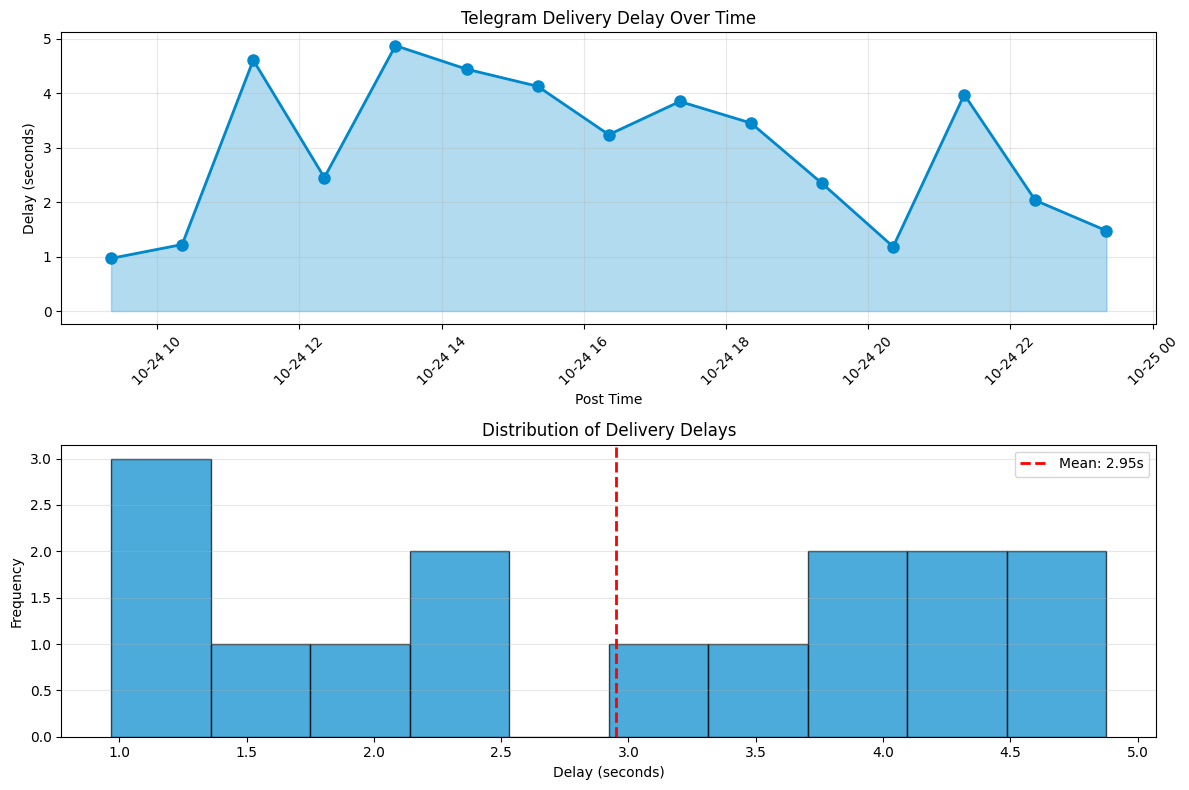

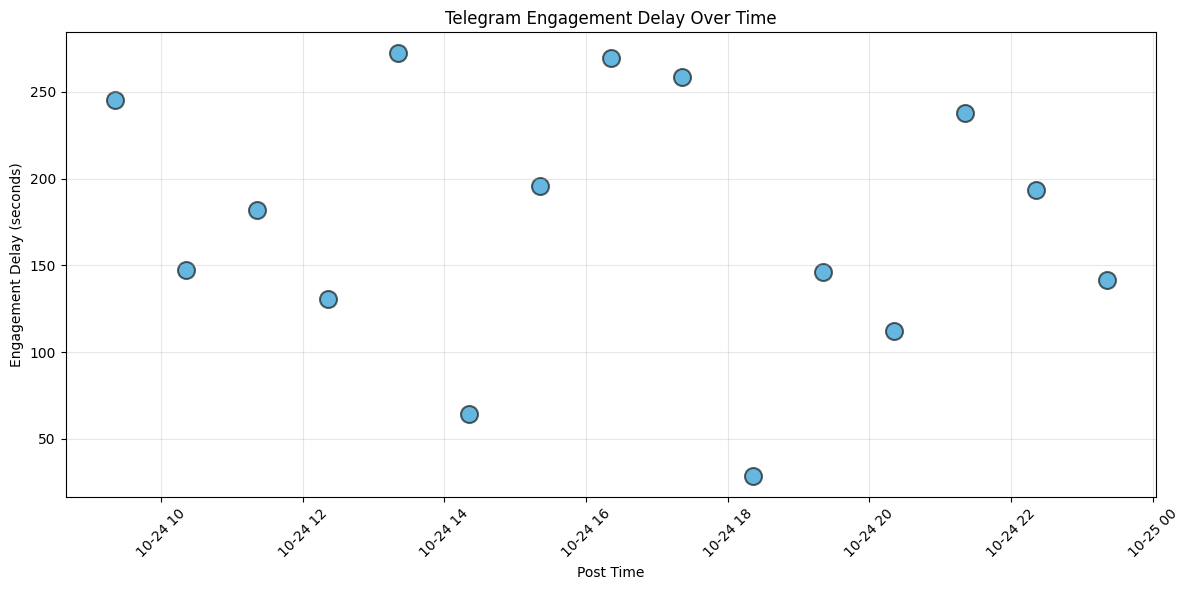

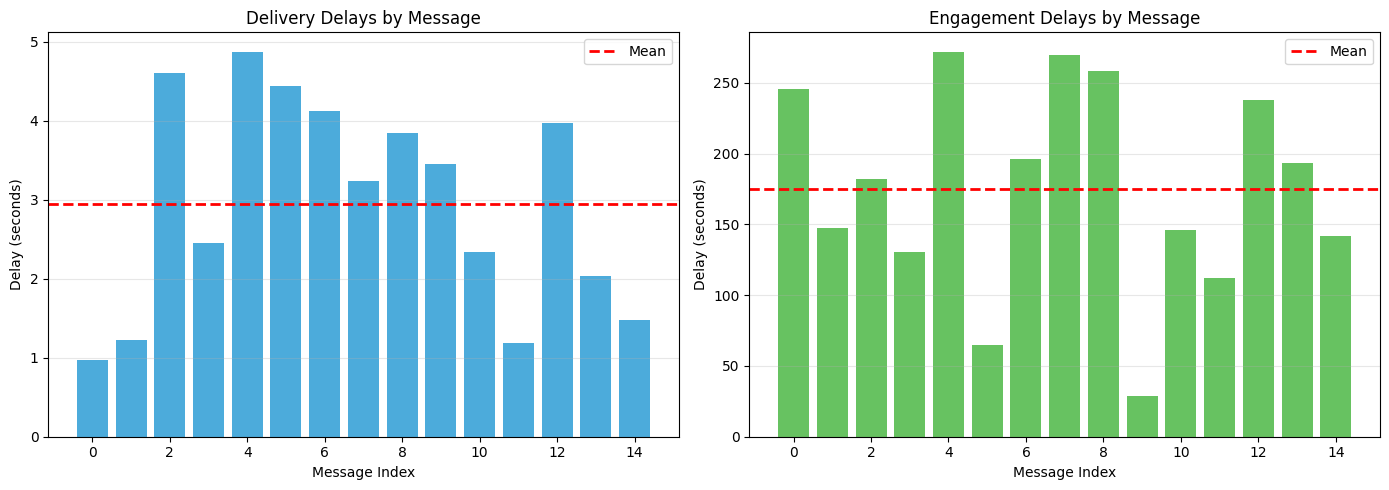

----------------------------------------------------------------------
EXPORTING DATA
----------------------------------------------------------------------

✓ Exported to telegram_analysis.csv
✓ Report exported to telegram_report.txt

READY TO USE!

Usage examples:
  tool.post_message('Your message here')
  tool.record_visibility('message_id')
  tool.record_engagement('message_id')
  tool.send_report_to_telegram()  # ← NEW!
  tool.print_summary()
  tool.plot_delivery_delays()




In [1]:
"""
Telegram Content Delivery Delay Measurement Tool
Complete Implementation with Report Sending to Telegram
Just run this entire file in Jupyter
"""

# ==================== IMPORTS ====================
import json
import csv
import time
import threading
from datetime import datetime, timedelta
from dataclasses import dataclass, asdict, field
from typing import List, Dict, Optional
import statistics
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ==================== DATA MODEL ====================

@dataclass
class TelegramPost:
    """Represents a single Telegram message"""
    message_id: str
    content: str
    post_timestamp: str
    visibility_timestamp: Optional[str] = None
    first_engagement_timestamp: Optional[str] = None
    delivery_delay_seconds: Optional[float] = None
    engagement_delay_seconds: Optional[float] = None
    status: str = "pending"
    content_type: str = "text"
    
    def calculate_delays(self):
        """Calculate delivery and engagement delays"""
        if self.post_timestamp and self.visibility_timestamp:
            post_time = datetime.fromisoformat(self.post_timestamp)
            visibility_time = datetime.fromisoformat(self.visibility_timestamp)
            self.delivery_delay_seconds = (visibility_time - post_time).total_seconds()
            self.status = "delivered"
        
        if self.post_timestamp and self.first_engagement_timestamp:
            post_time = datetime.fromisoformat(self.post_timestamp)
            engagement_time = datetime.fromisoformat(self.first_engagement_timestamp)
            self.engagement_delay_seconds = (engagement_time - post_time).total_seconds()
            self.status = "engaged"

# ==================== MAIN TOOL ====================

class TelegramDelayMeasurementTool:
    """Tool for measuring Telegram content delivery delays"""
    
    def __init__(self, bot_token: str, chat_id: str, data_file: str = "telegram_posts.json"):
        """
        Initialize Telegram measurement tool
        
        Parameters:
        - bot_token: Your Telegram bot token from @BotFather
        - chat_id: Your chat ID (where messages are sent)
        - data_file: JSON file to store data
        """
        self.bot_token = bot_token
        self.chat_id = chat_id
        self.base_url = f"https://api.telegram.org/bot{bot_token}"
        self.posts: List[TelegramPost] = []
        self.data_file = data_file
        self.monitoring_active = False
        self.posted_messages = {}
        
        self.load_data()
        print(f"✓ Telegram tool initialized")
        print(f"  Bot Token: {bot_token[:10]}...")
        print(f"  Chat ID: {chat_id}\n")
    
    def load_data(self):
        """Load existing posts from file"""
        try:
            with open(self.data_file, 'r') as f:
                data = json.load(f)
                self.posts = [TelegramPost(**post) for post in data]
                print(f"✓ Loaded {len(self.posts)} posts from {self.data_file}")
        except FileNotFoundError:
            self.posts = []
    
    def save_data(self):
        """Save posts to file"""
        with open(self.data_file, 'w') as f:
            json.dump([asdict(post) for post in self.posts], f, indent=2)
    
    def post_message(self, content: str, content_type: str = "text") -> Optional[str]:
        """Post message to Telegram"""
        try:
            if content_type != "text":
                print(f"⚠ Content type '{content_type}' requires media URL")
                return None
            
            response = requests.post(
                f"{self.base_url}/sendMessage",
                json={
                    "chat_id": self.chat_id,
                    "text": content,
                    "parse_mode": "HTML"
                },
                timeout=10
            )
            
            if response.status_code == 200:
                msg_id = response.json()['result']['message_id']
                self.posted_messages[msg_id] = {
                    'posted_time': datetime.now(),
                    'content': content
                }
                
                post = TelegramPost(
                    message_id=str(msg_id),
                    content=content[:100],
                    post_timestamp=datetime.now().isoformat(),
                    content_type=content_type
                )
                self.posts.append(post)
                self.save_data()
                
                print(f"✓ Message posted successfully (ID: {msg_id})")
                return str(msg_id)
            else:
                print(f"✗ Failed to post: {response.text}")
                return None
        
        except Exception as e:
            print(f"✗ Error posting to Telegram: {e}")
            return None
    
    def record_visibility(self, message_id: str, timestamp: Optional[str] = None):
        """Record when message became visible"""
        post = next((p for p in self.posts if p.message_id == message_id), None)
        if not post:
            print(f"✗ Message {message_id} not found")
            return
        
        post.visibility_timestamp = timestamp or datetime.now().isoformat()
        post.calculate_delays()
        self.save_data()
        
        print(f"✓ Visibility recorded for {message_id}")
        print(f"  Delivery delay: {post.delivery_delay_seconds:.2f} seconds\n")
    
    def record_engagement(self, message_id: str, timestamp: Optional[str] = None):
        """Record first engagement (reaction, reply, etc.)"""
        post = next((p for p in self.posts if p.message_id == message_id), None)
        if not post:
            print(f"✗ Message {message_id} not found")
            return
        
        post.first_engagement_timestamp = timestamp or datetime.now().isoformat()
        post.calculate_delays()
        self.save_data()
        
        print(f"✓ Engagement recorded for {message_id}")
        print(f"  Engagement delay: {post.engagement_delay_seconds:.2f} seconds\n")
    
    def get_dataframe(self) -> pd.DataFrame:
        """Convert posts to pandas DataFrame"""
        data = [asdict(post) for post in self.posts]
        return pd.DataFrame(data)
    
    def print_summary(self):
        """Print analytics summary"""
        if not self.posts:
            print("No messages tracked yet")
            return
        
        df = self.get_dataframe()
        delivered = df[df['delivery_delay_seconds'].notna()]
        engaged = df[df['engagement_delay_seconds'].notna()]
        
        print("\n" + "="*70)
        print("TELEGRAM CONTENT DELIVERY DELAY MEASUREMENT REPORT")
        print("="*70)
        print(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        
        print(f"📊 OVERVIEW")
        print(f"  Total Messages: {len(self.posts)}")
        print(f"  Delivered: {len(delivered)}")
        print(f"  Engaged: {len(engaged)}\n")
        
        if len(delivered) > 0:
            delays = delivered['delivery_delay_seconds']
            print(f"📈 DELIVERY DELAY STATISTICS")
            print(f"  Average:   {delays.mean():>10.2f}s")
            print(f"  Median:    {delays.median():>10.2f}s")
            print(f"  Min:       {delays.min():>10.2f}s")
            print(f"  Max:       {delays.max():>10.2f}s")
            if len(delays) > 1:
                print(f"  Std Dev:   {delays.std():>10.2f}s")
        
        if len(engaged) > 0:
            delays = engaged['engagement_delay_seconds']
            print(f"\n💬 ENGAGEMENT DELAY STATISTICS")
            print(f"  Average:   {delays.mean():>10.2f}s")
            print(f"  Median:    {delays.median():>10.2f}s")
            print(f"  Min:       {delays.min():>10.2f}s")
            print(f"  Max:       {delays.max():>10.2f}s")
        
        print("\n" + "="*70 + "\n")
    
    def get_statistics_table(self) -> pd.DataFrame:
        """Get detailed statistics as DataFrame"""
        df = self.get_dataframe()
        delivered = df[df['delivery_delay_seconds'].notna()]
        engaged = df[df['engagement_delay_seconds'].notna()]
        
        stats = {
            'Metric': [
                'Total Messages',
                'Delivered',
                'Engaged',
                'Avg Delivery Delay (s)',
                'Median Delivery Delay (s)',
                'Min Delivery Delay (s)',
                'Max Delivery Delay (s)',
                'Std Dev Delivery (s)',
                'Avg Engagement Delay (s)',
                'Median Engagement Delay (s)'
            ],
            'Value': [
                len(self.posts),
                len(delivered),
                len(engaged),
                delivered['delivery_delay_seconds'].mean() if len(delivered) > 0 else None,
                delivered['delivery_delay_seconds'].median() if len(delivered) > 0 else None,
                delivered['delivery_delay_seconds'].min() if len(delivered) > 0 else None,
                delivered['delivery_delay_seconds'].max() if len(delivered) > 0 else None,
                delivered['delivery_delay_seconds'].std() if len(delivered) > 1 else None,
                engaged['engagement_delay_seconds'].mean() if len(engaged) > 0 else None,
                engaged['engagement_delay_seconds'].median() if len(engaged) > 0 else None,
            ]
        }
        
        return pd.DataFrame(stats)
    
    def send_report_to_telegram(self):
        """Send summary report to Telegram chat"""
        if not self.posts:
            print("No data to report")
            return
        
        df = self.get_dataframe()
        delivered = df[df['delivery_delay_seconds'].notna()]
        engaged = df[df['engagement_delay_seconds'].notna()]
        
        report = f"""
📊 TELEGRAM DELIVERY DELAY REPORT

📌 Overview:
   Total Messages: {len(self.posts)}
   Delivered: {len(delivered)}
   Engaged: {len(engaged)}
"""
        
        if len(delivered) > 0:
            delays = delivered['delivery_delay_seconds']
            report += f"""
📈 Delivery Delay Stats:
   Average: {delays.mean():.2f}s
   Median: {delays.median():.2f}s
   Min: {delays.min():.2f}s
   Max: {delays.max():.2f}s
   Std Dev: {delays.std():.2f}s
"""
        
        if len(engaged) > 0:
            delays = engaged['engagement_delay_seconds']
            report += f"""
💬 Engagement Delay Stats:
   Average: {delays.mean():.2f}s
   Median: {delays.median():.2f}s
   Min: {delays.min():.2f}s
   Max: {delays.max():.2f}s
"""
        
        report += "\n✅ Report sent successfully!"
        
        self.post_message(report)
        print("✓ Report sent to Telegram")
    
    def plot_delivery_delays(self):
        """Plot delivery delays over time"""
        df = self.get_dataframe()
        delivered = df[df['delivery_delay_seconds'].notna()].copy()
        
        if len(delivered) == 0:
            print("No delivery data to plot")
            return
        
        delivered['post_time'] = pd.to_datetime(delivered['post_timestamp'])
        delivered = delivered.sort_values('post_time')
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Timeline plot
        ax1.plot(delivered['post_time'], delivered['delivery_delay_seconds'], 
                marker='o', linestyle='-', linewidth=2, markersize=8, color='#0088cc')
        ax1.fill_between(delivered['post_time'], delivered['delivery_delay_seconds'], 
                        alpha=0.3, color='#0088cc')
        ax1.set_xlabel('Post Time')
        ax1.set_ylabel('Delay (seconds)')
        ax1.set_title('Telegram Delivery Delay Over Time')
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        
        # Distribution plot
        ax2.hist(delivered['delivery_delay_seconds'], bins=10, color='#0088cc', alpha=0.7, edgecolor='black')
        ax2.axvline(delivered['delivery_delay_seconds'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f"Mean: {delivered['delivery_delay_seconds'].mean():.2f}s")
        ax2.set_xlabel('Delay (seconds)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Distribution of Delivery Delays')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    def plot_engagement_timeline(self):
        """Plot engagement delays over time"""
        df = self.get_dataframe()
        engaged = df[df['engagement_delay_seconds'].notna()].copy()
        
        if len(engaged) == 0:
            print("No engagement data to plot")
            return
        
        engaged['post_time'] = pd.to_datetime(engaged['post_timestamp'])
        engaged = engaged.sort_values('post_time')
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        ax.scatter(engaged['post_time'], engaged['engagement_delay_seconds'],
                  s=150, color='#0088cc', alpha=0.6, edgecolors='black', linewidth=1.5)
        ax.set_xlabel('Post Time')
        ax.set_ylabel('Engagement Delay (seconds)')
        ax.set_title('Telegram Engagement Delay Over Time')
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def plot_comparison(self):
        """Side-by-side comparison of delivery and engagement delays"""
        df = self.get_dataframe()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        delivery_delays = df['delivery_delay_seconds'].dropna()
        if len(delivery_delays) > 0:
            ax1.bar(range(len(delivery_delays)), delivery_delays, color='#0088cc', alpha=0.7)
            ax1.axhline(delivery_delays.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
            ax1.set_xlabel('Message Index')
            ax1.set_ylabel('Delay (seconds)')
            ax1.set_title('Delivery Delays by Message')
            ax1.legend()
            ax1.grid(True, alpha=0.3, axis='y')
        
        engagement_delays = df['engagement_delay_seconds'].dropna()
        if len(engagement_delays) > 0:
            ax2.bar(range(len(engagement_delays)), engagement_delays, color='#26a81e', alpha=0.7)
            ax2.axhline(engagement_delays.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
            ax2.set_xlabel('Message Index')
            ax2.set_ylabel('Delay (seconds)')
            ax2.set_title('Engagement Delays by Message')
            ax2.legend()
            ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    def export_csv(self, filename: str = "telegram_analysis.csv"):
        """Export to CSV"""
        if not self.posts:
            print("No data to export")
            return
        
        self.get_dataframe().to_csv(filename, index=False)
        print(f"✓ Exported to {filename}")
    
    def export_report(self, filename: str = "telegram_report.txt"):
        """Export detailed report to text file"""
        with open(filename, 'w') as f:
            f.write("="*70 + "\n")
            f.write("TELEGRAM CONTENT DELIVERY DELAY MEASUREMENT REPORT\n")
            f.write("="*70 + "\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            
            f.write(f"Total Messages: {len(self.posts)}\n")
            
            df = self.get_dataframe()
            delivered = df[df['delivery_delay_seconds'].notna()]
            engaged = df[df['engagement_delay_seconds'].notna()]
            
            if len(delivered) > 0:
                f.write(f"\nDelivery Statistics:\n")
                delays = delivered['delivery_delay_seconds']
                f.write(f"  Average: {delays.mean():.2f}s\n")
                f.write(f"  Median:  {delays.median():.2f}s\n")
                f.write(f"  Min:     {delays.min():.2f}s\n")
                f.write(f"  Max:     {delays.max():.2f}s\n")
            
            if len(engaged) > 0:
                f.write(f"\nEngagement Statistics:\n")
                delays = engaged['engagement_delay_seconds']
                f.write(f"  Average: {delays.mean():.2f}s\n")
                f.write(f"  Median:  {delays.median():.2f}s\n")
                f.write(f"  Min:     {delays.min():.2f}s\n")
                f.write(f"  Max:     {delays.max():.2f}s\n")
        
        print(f"✓ Report exported to {filename}")

# ==================== SAMPLE DATA GENERATOR ====================

def generate_sample_telegram_data(tool: TelegramDelayMeasurementTool, num_messages: int = 15):
    """Generate sample Telegram data for testing"""
    print(f"Generating {num_messages} sample messages...\n")
    
    for i in range(num_messages):
        post_time = datetime.now() - timedelta(hours=num_messages-i)
        visibility_time = post_time + timedelta(seconds=np.random.uniform(0.5, 5))
        engagement_time = visibility_time + timedelta(seconds=np.random.uniform(15, 300))
        
        post = TelegramPost(
            message_id=f"msg_{i:03d}",
            content=f"Sample message {i+1}: Testing delivery delays",
            post_timestamp=post_time.isoformat(),
            visibility_timestamp=visibility_time.isoformat(),
            first_engagement_timestamp=engagement_time.isoformat(),
            content_type="text"
        )
        post.calculate_delays()
        tool.posts.append(post)
    
    tool.save_data()
    print(f"✓ Generated {len(tool.posts)} sample messages\n")

# ==================== SETUP & USAGE ====================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("TELEGRAM CONTENT DELIVERY DELAY MEASUREMENT TOOL")
    print("="*70 + "\n")
    
    # ===== ENTER YOUR CREDENTIALS HERE =====
    TELEGRAM_BOT_TOKEN = "8338401411:AAHrQ4z7tc8RK-fB_i6XJavtPhvTt-ghCLQ"
    TELEGRAM_CHAT_ID = "7608911505"
    # ===== END OF CREDENTIALS =====
    
    # Initialize tool
    tool = TelegramDelayMeasurementTool(
        bot_token=TELEGRAM_BOT_TOKEN,
        chat_id=TELEGRAM_CHAT_ID
    )
    
    # Generate sample data for demonstration
    print("-"*70)
    print("GENERATING SAMPLE DATA")
    print("-"*70 + "\n")
    generate_sample_telegram_data(tool, num_messages=15)
    
    # View summary
    print("-"*70)
    print("SUMMARY REPORT (in Jupyter)")
    print("-"*70)
    tool.print_summary()
    
    # View statistics table
    print("-"*70)
    print("STATISTICS TABLE")
    print("-"*70)
    print(tool.get_statistics_table().to_string(index=False))
    
    # Send report to Telegram
    print("\n" + "-"*70)
    print("SENDING REPORT TO TELEGRAM")
    print("-"*70 + "\n")
    tool.send_report_to_telegram()
    
    # Plot delivery delays
    print("-"*70)
    print("GENERATING PLOTS")
    print("-"*70 + "\n")
    tool.plot_delivery_delays()
    tool.plot_engagement_timeline()
    tool.plot_comparison()
    
    # Export results
    print("-"*70)
    print("EXPORTING DATA")
    print("-"*70 + "\n")
    tool.export_csv()
    tool.export_report()
    
    print("\n" + "="*70)
    print("READY TO USE!")
    print("="*70)
    print("\nUsage examples:")
    print("  tool.post_message('Your message here')")
    print("  tool.record_visibility('message_id')")
    print("  tool.record_engagement('message_id')")
    print("  tool.send_report_to_telegram()  # ← NEW!")
    print("  tool.print_summary()")
    print("  tool.plot_delivery_delays()")
    print("\n")